In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

g = 9.81                   
sigma = 5.67e-8            #
So = 1363.0                # S
albedo = 0.3               #
cp = 1005.0                
p_surface = 100000.0       
dp = 5000.0                
num_layers = int(p_surface / dp)  # e.g., 20 layers
pressures_hPa = np.linspace(p_surface/100, dp/100, num_layers)
def get_emissivity(p_hPa):
    if p_hPa >= 800:
        return 0.3
    elif p_hPa >= 400:
        return 0.2
    else:
        return 0.1
    

    # Useful link
    # https://biocycle.atmos.colostate.edu/shiny/2layer/

Step 10000, sim_time = 1.30 days, dt = 11.918 s
Step 20000, sim_time = 2.71 days, dt = 13.110 s
Step 30000, sim_time = 4.50 days, dt = 19.194 s
Step 40000, sim_time = 8.81 days, dt = 49.785 s
Saved profile for 2 weeks at sim_time = 14.00 days
Step 50000, sim_time = 14.57 days, dt = 49.785 s
Step 60000, sim_time = 21.46 days, dt = 72.890 s
Saved profile for 1 month at sim_time = 30.00 days
Step 70000, sim_time = 30.59 days, dt = 88.197 s
Step 80000, sim_time = 42.05 days, dt = 106.719 s
Step 90000, sim_time = 55.31 days, dt = 129.130 s
Step 100000, sim_time = 71.70 days, dt = 156.247 s
Step 110000, sim_time = 92.76 days, dt = 207.965 s
Step 120000, sim_time = 117.68 days, dt = 251.638 s
Step 130000, sim_time = 154.46 days, dt = 490.371 s
Saved profile for 6 months at sim_time = 182.51 days
Saved profile for 1 year at sim_time = 365.56 days


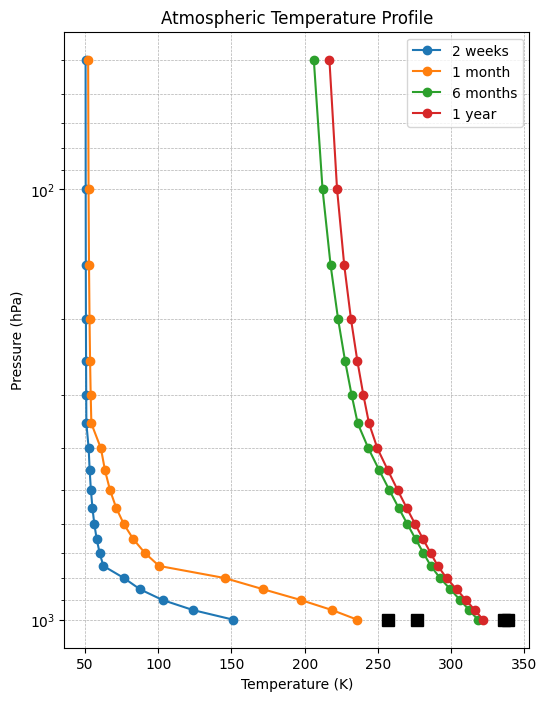

In [2]:

p_surface = 100000.0       # Surface pressure (Pa)
dp = 5000.0                # Pressure interval per layer (Pa)
num_layers = int(p_surface / dp)  # e.g., 20 layers
pressures_hPa = np.linspace(p_surface/100, dp/100, num_layers)  # 1000 hPa to 50 hPa
epsilon_atm = np.array([get_emissivity(p) for p in pressures_hPa])
epsilon_surf = 1.0
T_atm = np.full(num_layers, 50.0)   # Temperature for each atmospheric layer (K)
T_surf = 50.0                     # Surface temperature (K)
mass_atm = dp / g
mass_surf = (50 * 100.0) / g  

def compute_interface_fluxes(T_surf, T_atm, epsilon_atm):
    N = len(T_atm)
    F_up = np.zeros(N + 1)
    F_down = np.zeros(N + 1)
    F_up[0] = sigma * T_surf**4
    for i in range(N):
        eps = epsilon_atm[i]
        # Each layer absorbs flux from below and emits its own upward radiation.
        F_up[i+1] = (1 - eps) * F_up[i] + eps * sigma * T_atm[i]**4

    F_down[N] = 0.0
    for i in range(N-1, -1, -1):
        eps = epsilon_atm[i]
        F_down[i] = (1 - eps) * F_down[i+1] + eps * sigma * T_atm[i]**4
    return F_up, F_down

def compute_net_heating(T_surf, T_atm, epsilon_atm, So, albedo):
    F_up, F_down = compute_interface_fluxes(T_surf, T_atm, epsilon_atm)
    N = len(T_atm)
    F_net = F_up - F_down
    dF_lw = np.zeros(N)
    for i in range(N):
        dF_lw[i] = F_net[i] - F_net[i+1]
    F_abs = (So / 4.0) * (1 - albedo)
    dF_surf = F_down[0] + F_abs - F_up[0]
    return dF_lw, dF_surf

def derivatives(T_surf, T_atm):
    """
    Compute dT/dt for the surface and atmospheric layers.
    """
    dF_lw, dF_surf = compute_net_heating(T_surf, T_atm, epsilon_atm, So, albedo)
    dT_atm_dt = dF_lw / (mass_atm * cp)
    dT_surf_dt = dF_surf / (mass_surf * cp)
    return dT_surf_dt, dT_atm_dt

def rk4_step(T_surf, T_atm, dt):
    k1_s, k1_a = derivatives(T_surf, T_atm)
    k2_s, k2_a = derivatives(T_surf + 0.5*dt*k1_s, T_atm + 0.5*dt*k1_a)
    k3_s, k3_a = derivatives(T_surf + 0.5*dt*k2_s, T_atm + 0.5*dt*k2_a)
    k4_s, k4_a = derivatives(T_surf + dt*k3_s, T_atm + dt*k3_a)
    T_surf_new = T_surf + (dt/6.0) * (k1_s + 2*k2_s + 2*k3_s + k4_s)
    T_atm_new = T_atm + (dt/6.0) * (k1_a + 2*k2_a + 2*k3_a + k4_a)
    return T_surf_new, T_atm_new

targets = {"2 weeks": 14 * 24 * 3600,"1 month": 30 * 24 * 3600,"6 months": 182.5 * 24 * 3600,"1 year": 365 * 24 * 3600}
saved_profiles = {}  

sim_time = 0.0   
dt = 1.0        
target_max_change = 0.05  
max_steps = 5_000_000
step = 0
final_time = targets["1 year"]

while sim_time < final_time and step < max_steps:
    T_surf_new, T_atm_new = rk4_step(T_surf, T_atm, dt)
    max_change = max(abs(T_surf_new - T_surf), np.max(np.abs(T_atm_new - T_atm)))
    # If change is too large, reduce dt 
    if max_change > target_max_change:
        dt *= target_max_change / max_change
        continue
    # If change is very small, slightly increase dt to speed integration.
    if max_change < target_max_change / 10:
        dt *= 1.1

    # Accept the step.
    T_surf, T_atm = T_surf_new, T_atm_new
    sim_time += dt
    step += 1
    
    # Save profiles if we've reached or passed a target time (and not saved it before)
    for label, t_target in targets.items():
        if sim_time >= t_target and label not in saved_profiles:
            # Save a copy of the current state.
            saved_profiles[label] = (T_surf, T_atm.copy())
            print(f"Saved profile for {label} at sim_time = {sim_time/3600/24:.2f} days")
    
    # (Optional) print progress every 10000 steps.
    if step % 10000 == 0:
        print(f"Step {step}, sim_time = {sim_time/3600/24:.2f} days, dt = {dt:.3f} s")

plt.figure(figsize=(6,8))
for label, (T_surf_val, T_atm_profile) in saved_profiles.items():
    # Plot the atmospheric layers (each layer is associated with a pressure from pressures_hPa)
    plt.plot(T_atm_profile, pressures_hPa, marker='o', linestyle='-', label=label)
    # Also mark the surface temperature as a black square at 1000 hPa.
    plt.plot(T_surf_val, pressures_hPa[0], 'ks', markersize=8)

plt.gca().set_yscale('log')
plt.gca().invert_yaxis()  # Pressure decreases upward
plt.xlabel('Temperature (K)')
plt.ylabel('Pressure (hPa)')
plt.title('Atmospheric Temperature Profile')
plt.legend()
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.show()
